# Laboratorio 4
## Reconocimiento de audio (Shazam)
Integrantes:
Constanza Quintana
Sebastian Pizarro
Franco Castillo

In [18]:
pip install librosa numpy matplotlib scipy


# Celda de lectura de audio
Lee un fragmento del archivo de audio, comenzando en un tiempo específico y con una duración determinada.

In [13]:
import librosa
import numpy as np

# Leer una sección específica del archivo de audio
def load_audio_section(file_path, sr=22050, start=10, duration=10):
    y, sr = librosa.load(file_path, sr=sr, offset=start, duration=duration)
    return y, sr

# Calculo del espectrograma
calcula el espectrograma en escala dB (decibeles) de una señal de audio (array de audio) utilizando la Transformada Rápida de Fourier (STFT).

In [14]:
import librosa.display
import matplotlib.pyplot as plt

def compute_spectrogram(audio, sr, n_fft=2048, hop_length=512):
    S = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    S_dB = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    return S_dB

###MAPA DE CONSTELACION
1. generate_constellation_map:
Detecta picos locales significativos en un espectrograma para identificar características clave del audio, filtrando por un umbral opcional. Devuelve un mapa binario con las posiciones de los picos detectados.

2. plot_constellation_map:
Visualiza los picos detectados como puntos en un gráfico de tiempo vs. frecuencia, mostrando el mapa de constelación del audio. Es útil para interpretar los puntos clave del espectrograma.

In [15]:
from scipy.ndimage import maximum_filter

def generate_constellation_map(spectrogram, threshold=None):
    """
    Genera un mapa de constelación a partir de un espectrograma.

    Parameters:
    - spectrogram: Espectrograma en escala dB.
    - threshold: Umbral para detectar picos. Si es None, se calculará dinámicamente.

    Returns:
    - peaks: Mapa de picos detectados.
    """
    if threshold is None:
        threshold = np.percentile(spectrogram, 95)
    peaks = maximum_filter(spectrogram, size=20) == spectrogram
    peaks[spectrogram < threshold] = False
    return peaks

def plot_constellation_map(peaks, sr, hop_length):
    indices = np.argwhere(peaks)
    plt.figure(figsize=(12, 6))
    plt.scatter(indices[:, 1] * hop_length / sr, indices[:, 0], color='cyan', label='Constellation Points')
    plt.title('Constellation Map')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.legend()
    plt.grid()
    plt.show()



###Fingerprints
La función generate_fingerprints genera huellas digitales únicas para una canción utilizando los picos de su mapa de constelación. Combina pares de picos cercanos, considerando sus frecuencias y la diferencia de tiempo entre ellos, para crear hashes únicos mediante el algoritmo SHA-256. Estos hashes se asocian con un identificador de canción (song_id) y se almacenan en un archivo con el formato "hash_value tiempo song_id".

In [16]:
import hashlib

def generate_fingerprints(peaks, sr=22050, hop_length=512, song_id="Song_001", output_file="fingerprints.txt", fan_value=5):
    """
    Genera múltiples hashes (huellas digitales) para una canción basándose en su mapa de constelación.

    Parameters:
    - peaks: Mapa de constelación (array booleano).
    - sr: Frecuencia de muestreo.
    - hop_length: Longitud de salto en la STFT.
    - song_id: Identificador único de la canción.
    - output_file: Nombre del archivo para guardar las huellas digitales.
    - fan_value: Número máximo de puntos vecinos a considerar para cada hash.

    Output:
    - Guarda las huellas digitales en un archivo con formato:
      "hash_value tiempo song_id".
    """
    indices = np.argwhere(peaks)

    peak_list = []
    for f, t in indices:
        time_in_sec = t * hop_length / sr
        peak_list.append((f, time_in_sec))

    peak_list = sorted(peak_list, key=lambda x: (x[1], x[0]))

    fingerprints = []
    for i in range(len(peak_list)):
        f1, t1 = peak_list[i]
        for j in range(1, fan_value + 1):
            if i + j < len(peak_list):
                f2, t2 = peak_list[i + j]
                delta_t = t2 - t1
                if delta_t > 0:
                    hash_input = f"{f1}-{f2}-{delta_t:.4f}"
                    hash_value = hashlib.sha256(hash_input.encode()).hexdigest()
                    fingerprints.append((hash_value, t1))

    if output_file is not None:
        with open(output_file, 'a') as file:
            for hash_value, time in fingerprints:
                file.write(f"{hash_value}-{time:.4f}-{song_id}\n")

    print(f"Se generaron {len(fingerprints)} huellas digitales para la canción '{song_id}'.")
    print(f"Guardado en el archivo: {output_file}")
    return fingerprints


##Celda de ejecucion:
Esta celda integra las funciones definidas para procesar un archivo de audio, generar su espectrograma, calcular un mapa de constelación, y finalmente crear y guardar las huellas digitales, solo llama a las funciones para una utilizacion mas clara y precisa.

Ingrese la ruta del archivo de audio: /y2mate.com - JERE KLEIN  RAM Video Oficial  Prod Adkiboi x Mateo on the beatz  65.mp3
Ingrese el nombre o ID para la canción: jere
Audio cargado: 2462892 muestras, Frecuencia de muestreo: 22050 Hz


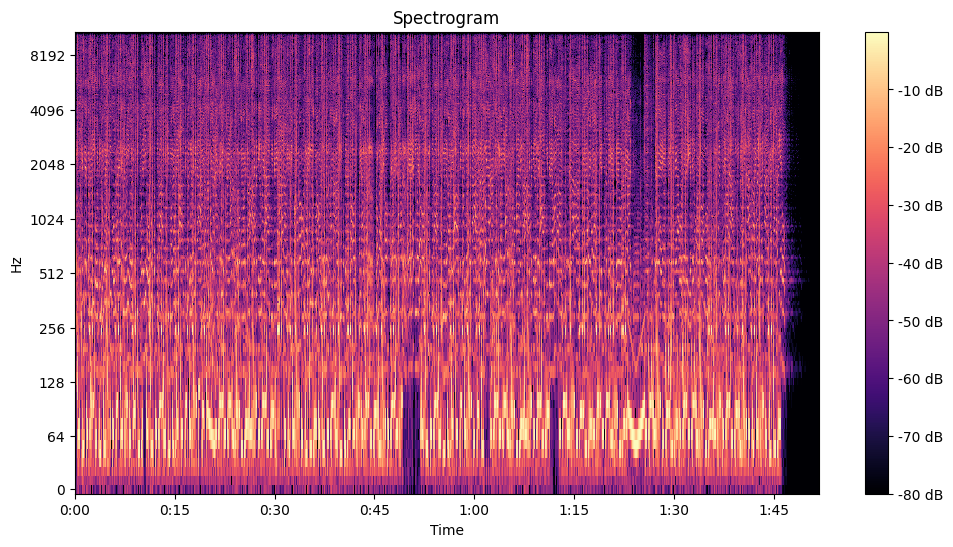

Se detectaron 6286 picos.


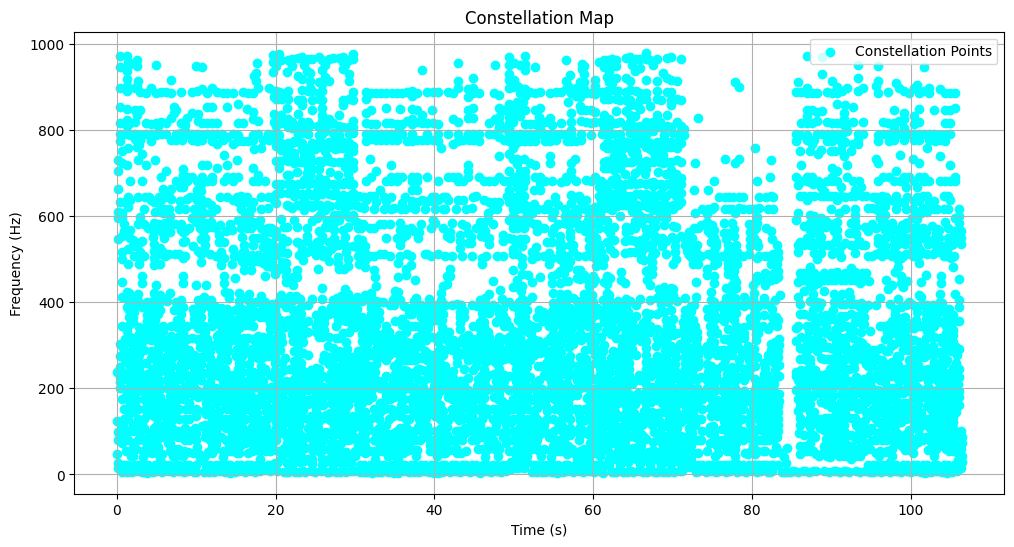

Se generaron 20726 huellas digitales para la canción 'jere'.
Guardado en el archivo: fingerprints.txt
Se generaron 20726 hashes para la canción 'jere'.
Guardados en el archivo: fingerprints.txt


In [17]:
file_path = input("Ingrese la ruta del archivo de audio: ")
song_id = input("Ingrese el nombre o ID para la canción: ")

audio, sr = load_audio_section(file_path, start=10, duration=None)
print(f"Audio cargado: {len(audio)} muestras, Frecuencia de muestreo: {sr} Hz")

spectrogram = compute_spectrogram(audio, sr)

plt.figure(figsize=(12, 6))
librosa.display.specshow(spectrogram, sr=sr, hop_length=512, x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

peaks = generate_constellation_map(spectrogram)

if np.sum(peaks) == 0:
    print("No se detectaron picos. Ajusta el umbral o revisa el archivo de audio.")
else:
    print(f"Se detectaron {np.sum(peaks)} picos.")

plot_constellation_map(peaks, sr=sr, hop_length=512)

output_file = "fingerprints.txt"

fingerprints = generate_fingerprints(peaks, sr=sr, hop_length=512, song_id=song_id, output_file=output_file, fan_value=5)

print(f"Se generaron {len(fingerprints)} hashes para la canción '{song_id}'.")
print(f"Guardados en el archivo: {output_file}")


# Algortimo de matching:
Esta es la función clave del programa, ya que se encarga de realizar la búsqueda y coincidencia de un fragmento de audio con las huellas digitales almacenadas en una base de datos. Al analizar el mapa de constelación del fragmento, genera los hashes correspondientes y los compara con las huellas digitales previamente almacenadas para identificar la canción correspondiente. La función no solo realiza la comparación, sino que también proporciona una métrica de similitud (número de coincidencias), que se utiliza para identificar la canción más probable.

In [12]:
from collections import defaultdict

def load_fingerprint_database(file_path="fingerprints.txt"):
    """
    Carga las huellas digitales desde un archivo de texto en un diccionario.

    Returns:
    - fingerprint_db: Diccionario {song_id: [hash1, hash2, ...]}.
    """
    fingerprint_db = defaultdict(list)
    with open(file_path, 'r') as file:
        for line in file:
            hash_value, time, song_id = line.strip().split('-')
            fingerprint_db[song_id].append(hash_value)
    return fingerprint_db

def match_audio_fragment(peaks, sr, hop_length, fingerprint_db, fan_value=5):
    """
    Compara las huellas digitales de un fragmento con la base de datos.

    Parameters:
    - peaks: Mapa de constelación del fragmento.
    - sr: Frecuencia de muestreo.
    - hop_length: Longitud de salto en la STFT.
    - fingerprint_db: Base de datos de huellas digitales.
    - fan_value: Número de puntos vecinos para generar hashes.

    Returns:
    - matches: Diccionario {song_id: número_de_coincidencias}.
    """
    indices = np.argwhere(peaks)
    peak_list = []
    for f, t in indices:
        time_in_sec = t * hop_length / sr
        peak_list.append((f, time_in_sec))
    peak_list = sorted(peak_list, key=lambda x: (x[1], x[0]))

    fragment_hashes = []
    for i in range(len(peak_list)):
        f1, t1 = peak_list[i]
        for j in range(1, fan_value + 1):
            if i + j < len(peak_list):
                f2, t2 = peak_list[i + j]
                delta_t = t2 - t1
                if delta_t > 0:
                    hash_input = f"{f1}-{f2}-{delta_t:.4f}"
                    hash_value = hashlib.sha256(hash_input.encode()).hexdigest()
                    fragment_hashes.append(hash_value)

    matches = defaultdict(int)
    for fragment_hash in fragment_hashes:
        for song_id, song_hashes in fingerprint_db.items():
            if fragment_hash in song_hashes:
                matches[song_id] += 1

    return matches

def identify_song(matches):
    """
    Identifica la canción con más coincidencias.

    Parameters:
    - matches: Diccionario {song_id: número_de_coincidencias}.

    Returns:
    - best_match: ID de la canción con más coincidencias.
    - max_matches: Número máximo de coincidencias.
    """
    if not matches:
        return None, 0
    best_match = max(matches, key=matches.get)
    max_matches = matches[best_match]
    return best_match, max_matches

fingerprint_db = load_fingerprint_database("fingerprints.txt")

file_path = input("Ingrese la ruta del fragmento de audio: ")
fragment_audio, sr = load_audio_section(file_path, start=10, duration=10)

fragment_spectrogram = compute_spectrogram(fragment_audio, sr)
fragment_peaks = generate_constellation_map(fragment_spectrogram)

matches = match_audio_fragment(fragment_peaks, sr, hop_length=512, fingerprint_db=fingerprint_db)

best_match, max_matches = identify_song(matches)
if best_match:
    print(f"La canción identificada es: {best_match} con {max_matches} coincidencias.")
else:
    print("No se encontró una coincidencia en la base de datos.")


Ingrese la ruta del fragmento de audio: /y2mate.com - JERE KLEIN  RAM Video Oficial  Prod Adkiboi x Mateo on the beatz  65.mp3
La canción identificada es: locura y maldad con 17 coincidencias.


# Mejoras
### Establecer un Mínimo de Coincidencias para Identificar una Canción:
Actualmente, el sistema devuelve una canción basada en el número de coincidencias entre las huellas digitales, pero no hay un umbral mínimo de coincidencias para declarar una identificación precisa. En situaciones en las que los "matches" son bajos, el sistema puede identificar una canción incorrecta o con una coincidencia deficiente.

# Conclusiones
El sistema es relativamente sencillo y eficaz para detectar coincidencias entre fragmentos de audio, permitiendo reconocer canciones basadas en patrones únicos. Sin embargo, el rendimiento de la identificación puede verse afectado por la calidad y precisión de las huellas digitales generadas, así como por la cantidad de coincidencias encontradas en la base de datos. Por lo tanto, si bien el algoritmo cumple su función, su precisión y efectividad dependen de varios factores, como la calidad del fragmento de audio, el tamaño de la base de datos y el umbral de coincidencias utilizado.